# Aggregating Population Change and Migration Types for Franklin and Delaware Counties from Census PEP data

## Introduction

This script is meant to take county-wide Census Pep data and filter for Franklin and Delaware from 2010-2021 and output two new agregated tables, one to focus on migration type and the other population change type, where the trends between the counties are combined.

### Process outline

The process carried out by this workflow can be described as follows:
  - The script will retrieve the Census PEP datasets from the local MORPC repo
  - Filter for only retain records from Franklin or Delawre, Ohio 2010-2021
  - Identify and keep only the rows containing the maximum 'Vintage' for each 'Year'
  - Copy values from Total_NPopChg to Total_NaturalInc, if Total_NPopChg==0
  - Transform tables to aggregate migration information by type and aggregate population growth information by type.
  - Create a stacked bar chart to distingush between international and domestic migration and another to distinguish between natrual population growth and net migration
  

## Setup

### Import required packages

In [226]:
import os
import pandas as pd
import matplotlib.pyplot as plt

### Parameters

In [227]:
# Define input and output directories
INPUT_DIR = "./input_data"
OUTPUT_DIR = "./output_data"

### Define inputs
The following datasets are required by this notebook. They will be retrieved from the specified location and temporarily stored in INPUT_DIR.

#### Census Pep country wide table

In [228]:
# Adjust the path to where the CSV file is located in your environment
file_path = "../morpc-censuspep-fetch/output_data/censusPep_county_wide.csv"

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

# Define the file path for the CSV
csv_file_path = os.path.join(INPUT_DIR, "censusPep_county_wide.csv")

# Save the census data to the input directory
data.to_csv(csv_file_path)

### Define outputs
The following datasets will be produced by the process described in this notebook.

#### Franklin and Delaware counties migration by type and year (2010-2021)

In [229]:
MIGRATION_TABLE_FILENAME = "migration_aggregated_data.csv"
MIGRATION_TABLE_PATH = os.path.join(OUTPUT_DIR, MIGRATION_TABLE_FILENAME)
MIGRATION_TABLE_SCHEMA_FILENAME = MIGRATION_TABLE_FILENAME.replace(".csv","_schema.json")
MIGRATION_TABLE_SCHEMA_PATH = os.path.join(OUTPUT_DIR, MIGRATION_TABLE_SCHEMA_FILENAME)
print("Data: {}".format(MIGRATION_TABLE_PATH))
print("Schema: {}".format(MIGRATION_TABLE_SCHEMA_PATH))

Data: ./output_data\migration_aggregated_data.csv
Schema: ./output_data\migration_aggregated_data_schema.json


#### Franklin and Delaware counties population change by type and year (2010-2021)

In [230]:
GROWTH_TABLE_FILENAME = "growth_aggregated_data.csv"
GROWTH_TABLE_PATH = os.path.join(OUTPUT_DIR, GROWTH_TABLE_FILENAME)
GROWTH_TABLE_SCHEMA_FILENAME = GROWTH_TABLE_FILENAME.replace(".csv","_schema.json")
GROWTH_TABLE_SCHEMA_PATH = os.path.join(OUTPUT_DIR, GROWTH_TABLE_SCHEMA_FILENAME)
print("Data: {}".format(GROWTH_TABLE_PATH))
print("Schema: {}".format(GROWTH_TABLE_SCHEMA_PATH))

Data: ./output_data\growth_aggregated_data.csv
Schema: ./output_data\growth_aggregated_data_schema.json


#### Get data from input directory

In [231]:
# Read the CSV file from input directory
data = pd.read_csv("input_data/censusPep_county_wide.csv")

### Filter for Ohio

In [232]:
# Filter for STNAME "Ohio"
data = data[data['STNAME'].isin(['Ohio'])]

### Filter for Delaware and Franklin counties

In [233]:
# Filter for CITYNAME "Delaware" and "Franklin"
data = data[data['CTYNAME'].isin(['Delaware', 'Franklin'])]

### Filter for 2010-2021

In [234]:
# Filter for Years between 2010-2021
data = data[(data['Year'] >= 2010) & (data['Year'] <= 2021)]

#Convert 'Year' variable type to Integer
data['Year'] = data['Year'].astype(int)

### Filter for maximum vintage for each year

In [235]:
# Step 1: Group by 'Year' and identify the maximum 'Vintage' for each 'Year'
max_vintage_per_year = data.groupby('Year')['Vintage'].transform("max")

# Step 2: Filter the original DataFrame to keep only rows with the maximum 'Vintage' for their 'Year'
data = data[data['Vintage'] == max_vintage_per_year]

### Combine records between Franklin and Delaware counties for each year

In [236]:
# Group by 'YEAR' and calculate sums for the specified columns
data = data.groupby('Year').agg(
    Total_Births=pd.NamedAgg(column='BIRTHS', aggfunc='sum'),
    Total_Deaths=pd.NamedAgg(column='DEATHS', aggfunc='sum'),
    Total_DomesticMig=pd.NamedAgg(column='DOMESTICMIG', aggfunc='sum'),
    Total_InternationalMig=pd.NamedAgg(column='INTERNATIONALMIG', aggfunc='sum'),
    Total_NaturalInc=pd.NamedAgg(column='NATURALINC', aggfunc='sum'),
    Total_NetMig=pd.NamedAgg(column='NETMIG', aggfunc='sum'),
    Total_NPopChg=pd.NamedAgg(column='NPOPCHG', aggfunc='sum'),
    Total_PopEstimate=pd.NamedAgg(column='POPESTIMATE', aggfunc='sum'),
    Total_Residual=pd.NamedAgg(column='RESIDUAL', aggfunc='sum')
).reset_index()

### Standardize natural population increase values

In [237]:
# Check if 'Total_NaturalInc' exists; if not, initialize it appropriately
if 'Total_NaturalInc' not in data.columns:
    # Initialize it based on your specific needs; placeholder initialization below
    data['Total_NaturalInc'] = 0.0 

# If 'Total_NaturalInc'==0, 'Total_NaturalInc' <- 'Total_NPopChg'
data['Total_NaturalInc'] = data.apply(
    lambda row: row['Total_NPopChg'] if row['Total_NaturalInc'] == 0.0 else row['Total_NaturalInc'],
    axis=1
)

### Aggregation for migration types

In [238]:
# Melt the DataFrame to "unpivot" the Total_DomesticMig and Total_InternationalMig columns
migration_data = pd.melt(data, id_vars=['Year'], value_vars=['Total_DomesticMig', 'Total_InternationalMig'], var_name='ChangeType', value_name='PopChange')

# Replace 'Total_DomesticMig' and 'Total_InternationalMig' with 'DomesticMig' and 'InternationalMig' respectively in the 'ChangeType' column
migration_data['ChangeType'] = migration_data['ChangeType'].map({'Total_DomesticMig': 'DomesticMig', 'Total_InternationalMig': 'InternationalMig'})

# Sort by 'Year'
migration_data_sorted = migration_data.sort_values(by='Year')

# Save the 'grouped_data' DataFrame to output directory
migration_data_sorted.to_csv(csv_file_path, index=False)

### Aggregation for population change types

In [239]:
# Melt the DataFrame to "unpivot" the Total_NaturalInc and Total_NetMig columns
growth_data = pd.melt(data, id_vars=['Year'], value_vars=['Total_NaturalInc', 'Total_NetMig'], var_name='ChangeType', value_name='PopChange')

# Replace 'Total_NaturalInc' and 'Total_NetMig' with 'NatGrowth' and 'Migration' respectively in the 'ChangeType' column
growth_data['ChangeType'] = growth_data['ChangeType'].map({'Total_NaturalInc': 'NatGrowth', 'Total_NetMig': 'Migration'})

# Sort by 'Year'
growth_data_sorted = growth_data.sort_values(by='Year')

# Define the file path for the CSV
csv_file_path = os.path.join(OUTPUT_DIR, "growth_aggregated_data.csv")

# Save the 'grouped_data' DataFrame to output directory
growth_data_sorted.to_csv(csv_file_path, index=False)

### Creating stacked bar chart for migration type

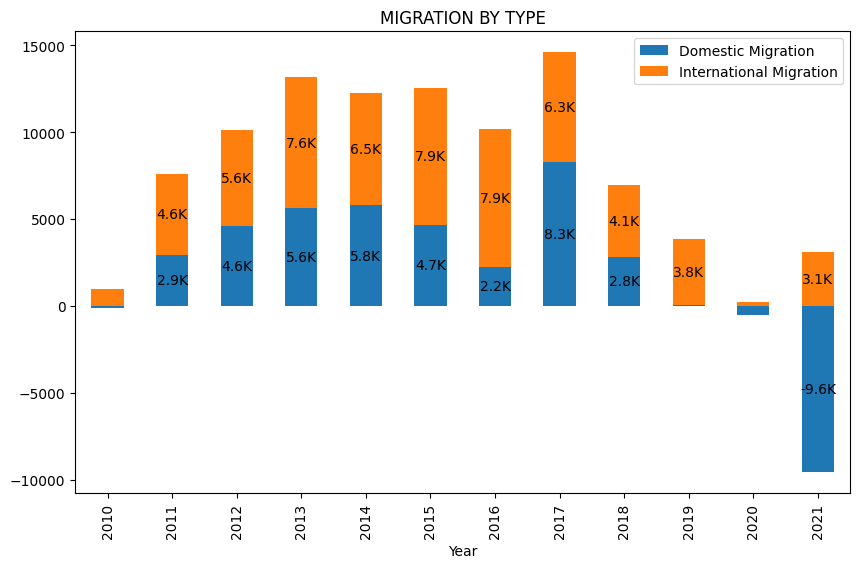

In [240]:
# Pivot the DataFrame to have 'Year' as the index, 'ChangeType' as the columns, and 'PopChange' as the values
pivoted_migration_data = migration_data_sorted.pivot(index='Year', columns='ChangeType', values='PopChange').fillna(0)

# Rename the columns for the legend
pivoted_migration_data.columns = ['Domestic Migration', 'International Migration']

# Plot the stacked bar chart
ax=pivoted_migration_data.plot(kind='bar', stacked=True, figsize=(10, 6))

# Adding labels to each bar, omitting labels for values less than 1.5K
for container in ax.containers:
    labels = [f'{x/1000:.1f}K' if abs(x) >= 1500 else '' for x in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='center')
plt.title('MIGRATION BY TYPE')

# Show the plot
plt.show()

### Creating stacked bar chart for population change type

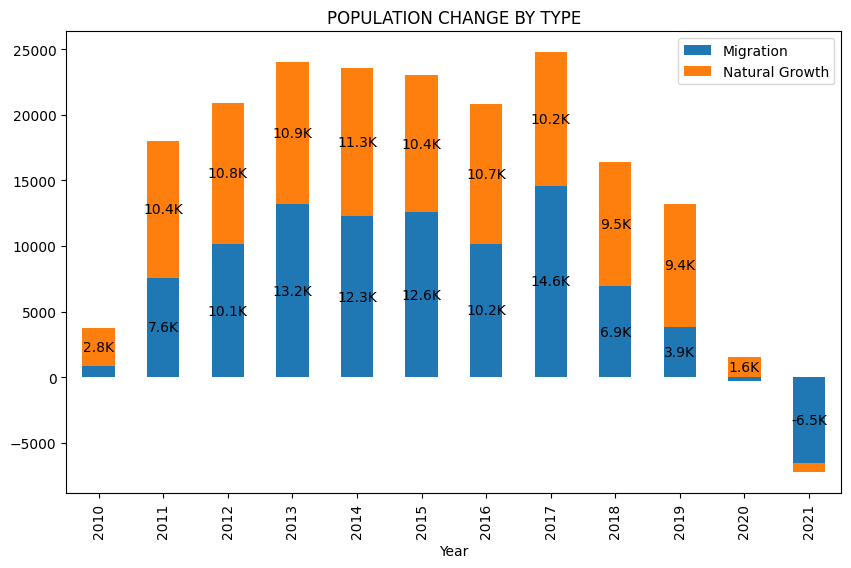

In [241]:
# Pivot the DataFrame to have 'Year' as the index, 'ChangeType' as the columns, and 'PopChange' as the values
pivoted_growth_data = growth_data_sorted.pivot(index='Year', columns='ChangeType', values='PopChange').fillna(0)

# Rename the columns for the legend
pivoted_growth_data.columns = ['Migration', 'Natural Growth']

# Plot the stacked bar chart
ax= pivoted_growth_data.plot(kind='bar', stacked=True, figsize=(10, 6))

# Adding labels to each bar, omitting labels for values less than 1.5K
for container in ax.containers:
    labels = [f'{x/1000:.1f}K' if abs(x) >= 1500 else '' for x in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='center')

plt.title('POPULATION CHANGE BY TYPE')

# Show the plot
plt.show()